In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from konlpy.tag import Okt  # 한글 자연어 처리 , 명사 형태소 추출 
from collections import Counter  #빈도 탐색 
import joblib # 학습데이터 저장

from matplotlib import rc 
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus']=False

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer # TF-IDF 변환 진행 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
data_set = pd.read_csv('hotel.csv')

data_set.head()

,Unnamed: 0,rating,text
0,0,4,여행에 집중할수 있게 편안한 휴식을 제공하는 호텔이었습니다. 위치선정 또한 적당한 ...
1,1,4,"2일 이상 연박시 침대, 이불, 베게등 침구류 교체 및 어메니티 보강이 필요해 보입..."
2,2,4,지인에소개로온 호텔 깨끗하고 좋은거같아요 처음에는 없는게 많아 많이 당황했는데 ...
3,3,5,방에 딱 들어서자마자 눈이 휘둥그레질정도로 이렇게 넓은 호텔 처음 와본 것 같아요!...
4,4,5,저녁에 맥주한잔 하는게 좋아서 렌트 안하고 뚜벅이 하기로 했는데 호텔 바로 앞에 버...


In [4]:
#데이터 셋 살펴보기 

data_set.shape

(906, 3)

In [5]:
#결측치 확인

data_set.isnull().sum()

Unnamed: 0    0
rating        0
text          0
dtype: int64

In [6]:
data_set.info() # 데이터 정보 확인 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 906 entries, 0 to 905
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  906 non-null    int64 
 1   rating      906 non-null    int64 
 2   text        906 non-null    object
dtypes: int64(2), object(1)
memory usage: 21.4+ KB


In [7]:
# 데이터 셋 텍스트 형태 확인

data_set['text'][0]

'여행에 집중할수 있게 편안한 휴식을 제공하는 호텔이었습니다. 위치선정 또한 적당한 편이었고 청소나 청결상태도 좋았습니다.'

In [8]:
data_set['text'][100]

'올 봄에 벚꽃기간에 방문, 협재를 바라보는 바다뷰가 좋고 대로변이라 렌트해서 가기도 좋음. 조식은 이용안했는데 근처 옹포밥집까지 아침 산책겸 걸어가서 하고옴. 루프탑 수영장과 바가 있었는데 내가 갔을때는 밤에 비바람이 너무 불어서 이용못하고옴 ㅠㅠ  단점으로는 모 유명 여행블로거 리뷰처럼 화장실 물떄가... 그거빼곤 다 만족'

In [9]:
def apply_new_set(text):
    korean = re.compile('[^ ㄱ-ㅣ 가-힣]') # 정규 표현식으로 단순 ㄱ 부터 ㅣ 까지 , 가 -힣 까지 한국어 추출 진행 
    result = korean.sub('', text) # 위 규칙을 테스트 셋 내에 text에 적용 
    return result # 결과 값 반환 

In [10]:
apply_new_set(data_set['text'][0]) #특수문자 제거 확인가능 

'여행에 집중할수 있게 편안한 휴식을 제공하는 호텔이었습니다 위치선정 또한 적당한 편이었고 청소나 청결상태도 좋았습니다'

In [11]:
okt = Okt() # 명사 형태소 추출
nouns = okt.nouns(apply_new_set(data_set['text'][0]))
nouns

['여행', '집중', '휴식', '제공', '호텔', '위치', '선정', '또한', '청소', '청결', '상태']

In [12]:
# 말 뭉치 생성하기
corpus = "".join(data_set['text'].tolist())
nouns = okt.nouns(apply_new_set(corpus))

nouns  # 전체 말뭉치 중에서 명사 형태소 추출 

['여행',
 '집중',
 '휴식',
 '제공',
 '호텔',
 '위치',
 '선정',
 '또한',
 '청소',
 '청결',
 '상태',
 '일',
 '이상',
 '연',
 '침대',
 '이불',
 '등',
 '침구',
 '류',
 '교체',
 '및',
 '어메니티',
 '보강',
 '베스트',
 '웨스턴',
 '회원',
 '경우',
 '객실',
 '뷰',
 '층수',
 '요청',
 '적극',
 '반영',
 '지인',
 '소개',
 '온',
 '호텔',
 '거',
 '처음',
 '당황',
 '세면',
 '도구',
 '잠옷',
 '필수',
 '그것',
 '방',
 '눈',
 '정도',
 '호텔',
 '처음',
 '것',
 '다음',
 '제주도',
 '꼭',
 '여기',
 '박만',
 '저녁',
 '맥주',
 '한잔',
 '렌트',
 '안',
 '뚜벅',
 '호텔',
 '바로',
 '앞',
 '버스',
 '정류',
 '시',
 '도착',
 '가방',
 '일찍',
 '정비',
 '방이',
 '바로',
 '입실',
 '룸',
 '업그레이드',
 '직원',
 '정말',
 '바다',
 '전망',
 '영',
 '전일',
 '함덕',
 '대명',
 '콘도',
 '곳',
 '실내',
 '분위기',
 '바다',
 '전망',
 '훨',
 '손님',
 '날',
 '가장',
 '바다',
 '방',
 '배치',
 '대해',
 '바로',
 '대응',
 '써비스',
 '조식',
 '부분',
 '신경',
 '아주',
 '특급',
 '호텔',
 '트랜디',
 '대해',
 '고민',
 '흔적',
 '여름',
 '꼭',
 '수영장',
 '사용',
 '보고',
 '엄마',
 '둘',
 '여행',
 '가격',
 '대비',
 '위치',
 '주위',
 '마트',
 '식당',
 '시장',
 '앞',
 '바다',
 '더',
 '또',
 '방문',
 '의사',
 '딸',
 '둘',
 '동안',
 '제주',
 '여행',
 '줌',
 '박',
 '숙소',
 '정해진',
 '제주',
 '휘슬',
 '락',
 '호

In [13]:
# 빈도 탐색
counter = Counter(nouns)

counter.most_common(10) # 해당 명사가 얼마나 나왔는지를 탐색 너무많아서 가장많은 top10만 선정 

[('호텔', 783),
 ('수', 484),
 ('것', 419),
 ('방', 324),
 ('위치', 323),
 ('우리', 316),
 ('곳', 314),
 ('공항', 302),
 ('직원', 256),
 ('매우', 250)]

In [14]:
# 한글자 명사 제거 # 분석하는것에 있어서 한글자는 불필요하기 때문에 
one_word_delete = Counter({x: counter[x] for x in counter if len(x) > 1})

one_word_delete.most_common(10) # 한글자가 사라진걸 확인 가능 

[('호텔', 783),
 ('위치', 323),
 ('우리', 316),
 ('공항', 302),
 ('직원', 256),
 ('매우', 250),
 ('가격', 244),
 ('객실', 235),
 ('시설', 212),
 ('제주', 189)]

In [15]:
stopwords = pd.read_csv('korean stopwords.txt').values.tolist() # 한국 불용어 사전 참고하여 불필요한 단어들 제거 진행

# 불용어들 사전 추가
hotel_stopwords = ['제주', '제주도', '호텔', '리뷰', '숙소', '여행', '트립'] # 해당 단어들은 분석에 불필요 함으로 내용들 추가 
for word in hotel_stopwords:
    stopwords.append(word) # 해당 리스트 내용 저장 

In [16]:
# BoW 벡터 생성


def text_clean(text):
    korean = re.compile('[^ ㄱ-ㅣ 가-힣]')  # 정규표현식 처리
    result = korean.sub('', text)
    okt = Okt()  # 형태소 추출
    nouns_1 = okt.nouns(result)
    nouns_2 = [x for x in nouns_1 if len(x) > 1]  # 한글자 키워드 제거
    nouns_3 = [x for x in nouns_2 if x not in stopwords]  # 불용어 제거
    return nouns_3


vect = CountVectorizer(tokenizer=lambda x: text_clean(x))
bow_vect = vect.fit_transform(data_set['text'].tolist())
word_list = vect.get_feature_names()  # 리뷰 등장 단어
count_list = bow_vect.toarray().sum(axis=0)  

In [17]:
word_list #단어 리스트 확인

['가가',
 '가게',
 '가격',
 '가격표',
 '가구',
 '가급',
 '가기',
 '가까이',
 '가끔',
 '가능',
 '가도',
 '가동',
 '가두',
 '가득',
 '가든',
 '가라',
 '가량',
 '가려움',
 '가로',
 '가면',
 '가몬',
 '가무',
 '가물',
 '가방',
 '가버',
 '가성',
 '가세',
 '가스레인지',
 '가스렌지',
 '가슴',
 '가시',
 '가신',
 '가야',
 '가옥',
 '가요',
 '가용',
 '가운데',
 '가을',
 '가인',
 '가장',
 '가정',
 '가정식',
 '가족',
 '가지',
 '가짓수',
 '가차',
 '가치',
 '가품',
 '각각',
 '각오',
 '각자',
 '각종',
 '각층',
 '간격',
 '간곳',
 '간다',
 '간단',
 '간만',
 '간식',
 '간이',
 '간주',
 '간직',
 '간판',
 '간혹',
 '갈껄',
 '갈비',
 '갈비탕',
 '갈수',
 '갈수록',
 '감각',
 '감동',
 '감명',
 '감사',
 '감상',
 '감소',
 '감안',
 '감자',
 '감히',
 '갑인',
 '갑자기',
 '갑작스레',
 '강남',
 '강력',
 '강아지',
 '강압',
 '강제',
 '강조',
 '강추',
 '개념',
 '개략',
 '개미',
 '개발',
 '개방',
 '개별',
 '개보',
 '개뿔',
 '개선',
 '개수대',
 '개월',
 '개인',
 '개인실',
 '개인정보',
 '개조',
 '개층',
 '객수',
 '객실',
 '갤러리',
 '갱스터',
 '거기',
 '거나',
 '거두',
 '거론',
 '거르세',
 '거름',
 '거리',
 '거린데',
 '거림',
 '거문도',
 '거미',
 '거부',
 '거실',
 '거여',
 '거울',
 '거위',
 '거의',
 '거절',
 '거주',
 '거지',
 '거참',
 '거품',
 '걱정',
 '건가',
 '건강',
 '건너',
 '건너편',
 '건물',
 '건의',
 '건조',
 '건조기',

In [18]:
count_list # 위 단어 리스트 당 총 등장 횟수 

array([  4,   8, 244, ...,   1,   7,  14])

In [19]:
# 각 단어의 리뷰별 등장 횟수 

bow_vect.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 2, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [20]:
bow_vect.shape  # 형태 출력 

(906, 3575)

In [21]:
word_dict = dict(zip(word_list, count_list))  # dict으로 위 출현 단어와 총 등장 횟수 묶기

word_dict

{'가가': 4,
 '가게': 8,
 '가격': 244,
 '가격표': 1,
 '가구': 8,
 '가급': 1,
 '가기': 20,
 '가까이': 20,
 '가끔': 5,
 '가능': 10,
 '가도': 7,
 '가동': 2,
 '가두': 1,
 '가득': 2,
 '가든': 1,
 '가라': 3,
 '가량': 1,
 '가려움': 1,
 '가로': 2,
 '가면': 14,
 '가몬': 1,
 '가무': 1,
 '가물': 1,
 '가방': 4,
 '가버': 1,
 '가성': 48,
 '가세': 3,
 '가스레인지': 1,
 '가스렌지': 1,
 '가슴': 1,
 '가시': 4,
 '가신': 2,
 '가야': 10,
 '가옥': 1,
 '가요': 5,
 '가용': 1,
 '가운데': 3,
 '가을': 4,
 '가인': 1,
 '가장': 41,
 '가정': 2,
 '가정식': 2,
 '가족': 93,
 '가지': 54,
 '가짓수': 3,
 '가차': 1,
 '가치': 13,
 '가품': 1,
 '각각': 7,
 '각오': 1,
 '각자': 2,
 '각종': 3,
 '각층': 1,
 '간격': 2,
 '간곳': 1,
 '간다': 4,
 '간단': 1,
 '간만': 1,
 '간식': 5,
 '간이': 3,
 '간주': 1,
 '간직': 1,
 '간판': 1,
 '간혹': 1,
 '갈껄': 1,
 '갈비': 1,
 '갈비탕': 1,
 '갈수': 7,
 '갈수록': 1,
 '감각': 1,
 '감동': 12,
 '감명': 1,
 '감사': 6,
 '감상': 3,
 '감소': 1,
 '감안': 5,
 '감자': 1,
 '감히': 1,
 '갑인': 1,
 '갑자기': 4,
 '갑작스레': 1,
 '강남': 1,
 '강력': 9,
 '강아지': 7,
 '강압': 2,
 '강제': 1,
 '강조': 1,
 '강추': 8,
 '개념': 1,
 '개략': 1,
 '개미': 1,
 '개발': 3,
 '개방': 2,
 '개별': 3,
 '개보': 1,
 '개뿔': 1,
 '개선': 4,


In [22]:
# TF -IDF 변환
tfidf_vectorizer = TfidfTransformer()
tf_idf_vect = tfidf_vectorizer.fit_transform(bow_vect)

tf_idf_vect.shape

#  변환했을때 906x3575 matrix가 출력됨
# 한 행(row)는 리뷰 / 한 열(column)은 한 단어

(906, 3575)

In [23]:
# 첫번째 리뷰에서의 단어 중요도 (TF-IDF 값) 0이 아닌것만 출력하기
print(tf_idf_vect[0])

  (0, 3564)	0.35591927261650264
  (0, 2910)	0.25808708732545355
  (0, 2908)	0.32175014730538015
  (0, 2849)	0.48985381608073525
  (0, 2679)	0.22939281214025123
  (0, 2295)	0.15121772876014272
  (0, 1574)	0.48985381608073525
  (0, 1519)	0.29091317022220425
  (0, 787)	0.25131158116077806


In [24]:
# 첫번째 리뷰에서 모든 단어의 중요도 --0인 값까지 포함
print(tf_idf_vect[0].toarray().shape)
print(tf_idf_vect[0].toarray())

(1, 3575)
[[0. 0. 0. ... 0. 0. 0.]]


In [25]:
## 벡터 - 단어 맵핑
invert_index = {v: k for k, v in vect.vocabulary_.items()}

invert_index

{2849: '집중',
 3564: '휴식',
 2679: '제공',
 2295: '위치',
 1574: '선정',
 787: '또한',
 2910: '청소',
 2908: '청결',
 1519: '상태',
 2376: '이상',
 3005: '침대',
 2372: '이불',
 3004: '침구',
 297: '교체',
 1998: '어메니티',
 1289: '보강',
 1270: '베스트',
 2283: '웨스턴',
 3541: '회원',
 183: '경우',
 105: '객실',
 2992: '층수',
 2218: '요청',
 2590: '적극',
 1183: '반영',
 2820: '지인',
 1619: '소개',
 2893: '처음',
 608: '당황',
 1597: '세면',
 672: '도구',
 2539: '잠옷',
 3338: '필수',
 359: '그것',
 2656: '정도',
 575: '다음',
 2058: '여기',
 1166: '박만',
 2579: '저녁',
 977: '맥주',
 3393: '한잔',
 835: '렌트',
 788: '뚜벅',
 1154: '바로',
 1240: '버스',
 2659: '정류',
 694: '도착',
 23: '가방',
 2471: '일찍',
 2668: '정비',
 1218: '방이',
 2484: '입실',
 2023: '업그레이드',
 2832: '직원',
 2663: '정말',
 1143: '바다',
 2607: '전망',
 2620: '전일',
 3404: '함덕',
 621: '대명',
 3074: '콘도',
 1848: '실내',
 1376: '분위기',
 1647: '손님',
 39: '가장',
 1234: '배치',
 648: '대해',
 631: '대응',
 1876: '써비스',
 2713: '조식',
 1343: '부분',
 1825: '신경',
 1909: '아주',
 3188: '특급',
 3172: '트랜디',
 208: '고민',
 3569: '흔적',
 2066: '여

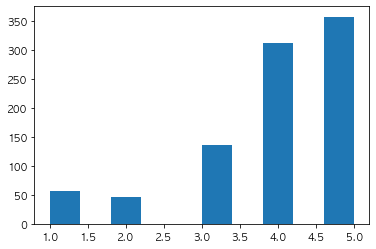

In [26]:
plt.hist(data_set['rating']) # 레이팅 시각화
plt.show() # 시각화 실행 # 3을 기준으로 4,5 는 긍정으로 1  1~3까지는 부정으로 분류하여 0으로 부여할 계획 

In [27]:
def add_label(rating):  # 3점이상일 경우 1 그 외 경우 0 으로 분류
    if rating > 3:
        return 1
    else:
        return 0


data_set['y'] = data_set['rating'].apply(lambda x: add_label(x))  # 분류하여 데이터셋 y 에 0 또는 1 표시

print(data_set['y'].value_counts()) # 1 or 0의 개수 표시  1 : 668 개 0 : 238개인것을 확인 

1    668
0    238
Name: y, dtype: int64


In [28]:
positive_random_idx = data_set[data_set['y'] == 1].sample(275, random_state=12, replace=True).index.tolist()
negative_random_idx = data_set[data_set['y'] == 0].sample(275, random_state=12, replace=True).index.tolist()


random_idx = positive_random_idx + negative_random_idx

random_idx

[896,
 491,
 316,
 297,
 843,
 322,
 542,
 347,
 54,
 857,
 607,
 527,
 587,
 831,
 89,
 483,
 472,
 130,
 253,
 334,
 101,
 112,
 361,
 126,
 529,
 525,
 145,
 569,
 442,
 180,
 599,
 258,
 165,
 836,
 822,
 774,
 520,
 136,
 724,
 421,
 27,
 279,
 616,
 766,
 631,
 374,
 250,
 303,
 469,
 250,
 385,
 820,
 214,
 70,
 616,
 245,
 822,
 843,
 190,
 585,
 68,
 759,
 103,
 449,
 224,
 225,
 631,
 293,
 617,
 711,
 519,
 131,
 244,
 218,
 643,
 194,
 834,
 633,
 829,
 647,
 771,
 827,
 114,
 624,
 126,
 756,
 319,
 138,
 182,
 267,
 67,
 226,
 813,
 806,
 578,
 883,
 511,
 681,
 229,
 189,
 725,
 2,
 578,
 542,
 307,
 197,
 408,
 828,
 62,
 530,
 743,
 854,
 92,
 889,
 409,
 347,
 578,
 433,
 780,
 846,
 806,
 182,
 351,
 134,
 118,
 235,
 481,
 276,
 203,
 870,
 238,
 121,
 120,
 826,
 196,
 643,
 217,
 258,
 18,
 870,
 536,
 453,
 192,
 652,
 771,
 594,
 577,
 698,
 483,
 730,
 50,
 475,
 345,
 368,
 773,
 605,
 16,
 92,
 397,
 868,
 288,
 192,
 340,
 324,
 76,
 101,
 181,
 353,
 179,
 

In [29]:
# 모델 Feature 변수는 리뷰에서 추출된 형태소와 그들의 중요도를 나타내는 tf_idf_vect로 대체

x = tf_idf_vect[random_idx]
y = data_set['y'][random_idx]

In [30]:
# Training set / Test set 나누기
x = tf_idf_vect[random_idx]  # 리뷰 , 단어
y = data_set['y'][random_idx]  # 0,1 에 대해 표시한 데이터 셋
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1, stratify=y, shuffle=True)
std = StandardScaler(with_mean=False)

In [31]:
print(f'dimension -> {np.ndim(x_train)}')
print(x_train.shape, y_train.shape)  # x_train , y_train의 형태
print(x_test.shape, y_test.shape)  # x_test , y_test의 형태
x_train_std = std.fit_transform(x_train, y_train)
x_test_std = std.fit_transform(x_test, y_test)

dimension -> 2
(440, 3575) (440,)
(110, 3575) (110,)


In [32]:
# 랜덤 포레스트 정확률 측정 

rf = RandomForestClassifier(n_estimators=100,n_jobs=-1)  
# n_estimators : 결정 트리를 100개정도 사용  
#n_jobs : 프로세스를 얼마나 활용할것인지 -1 전부활용
rf.fit(x_train_std, y_train)
# rf_model = joblib.dump(rf , 'rf.pkl') # 랜덤포레스트 학습데이터 pickle로 저장  (정확률 : 85%)
print(rf.score(x_test_std, y_test)) # 랜덤포레스트 정확률 

0.8363636363636363


In [33]:
# 모델학습 Logistic Regression 모델 학습 (로지스틱 회귀 사용)
lr = LogisticRegression(random_state=2021, C=2.0, max_iter=1000,n_jobs=-1) 
# C : 자유도를 얼마나 규제할것인지 수가 높을 수록 규제를 풀어줌 default값은 1.0
# max_iter : 경사하강법을 몇번 실행할것인지
lr.fit(x_train_std, y_train)  # x_train , y_train 각 학습
# lr_model = joblib.dump(lr , './logistic.pkl') # 로지스틱 회귀 데이터 pickle로 저장 ( 정확률 : 88%)
y_pred = lr.predict(x_test_std)
print('정확성 (accuracy) : %.2f' % accuracy_score(y_test, y_pred))
print('정밀도 (precision) : %.2f' % precision_score(y_test, y_pred))
print('재현율 (recall) : %.2f' % recall_score(y_test, y_pred)) 
print('F1  : %.2f' % f1_score(y_test, y_pred)) # 정확률 88프로 확인 

정확성 (accuracy) : 0.86
정밀도 (precision) : 0.80
재현율 (recall) : 0.96
F1  : 0.88


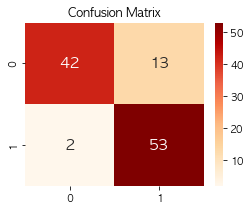

In [34]:
# << confusion matrix >>
from sklearn.metrics import confusion_matrix

confu = confusion_matrix(y_true=y_test, y_pred=y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(confu, annot=True, annot_kws={'size': 15}, cmap='OrRd', fmt='.10g')
plt.title('Confusion Matrix')
plt.show()

<BarContainer object of 3575 artists>

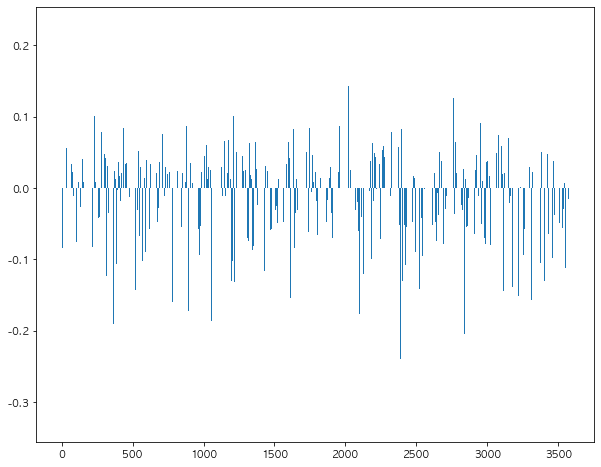

In [35]:
# 긍정 / 부정 키워드 분석 

plt.figure(figsize = (10 , 8))

plt.bar(range(len(lr.coef_[0])) , lr.coef_[0])

In [36]:
coef_pos_index = sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse = True)
coef_neg_index = sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse = False)
invert_index_vectorizer = {v: k for k, v in vect.vocabulary_.items()}

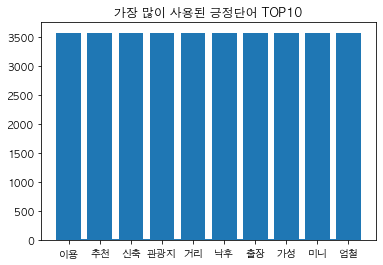

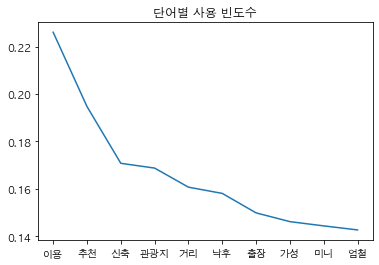

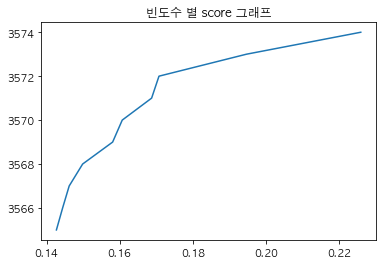

이용 0.2260284171603564
추천 0.19471668323983546
신축 0.17077938645683027
관광지 0.16876009909753226
거리 0.16071684864231323
낙후 0.1580913724178139
출장 0.14987735180449321
가성 0.14619025079657225
미니 0.14439783035350434
엄철 0.14269768729543217


In [37]:
pos_top10_str = [invert_index_vectorizer[coef[1]] for coef in coef_pos_index[:10]]
pos_top10_score = [coef[0] for coef in coef_pos_index[:10]]
text = [int(x) for x in invert_index_vectorizer]

text.sort()
text.reverse()
text_score_top = text[:10]

plt.bar(pos_top10_str, text_score_top)
plt.plot(pos_top10_score)
plt.title('가장 많이 사용된 긍정단어 TOP10')
plt.show()

plt.plot(pos_top10_str,pos_top10_score)
plt.title('단어별 사용 빈도수')
plt.show()

plt.plot(pos_top10_score, text_score_top)
plt.title('빈도수 별 score 그래프')
plt.show()


for coef in coef_pos_index[:10]:
    print(invert_index_vectorizer[coef[1]], coef[0])

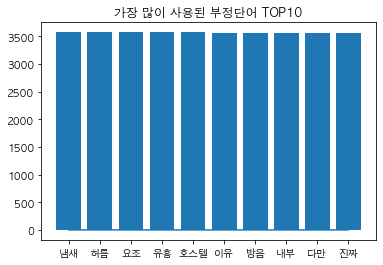

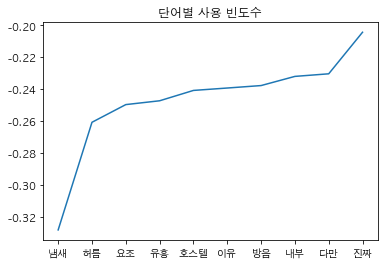

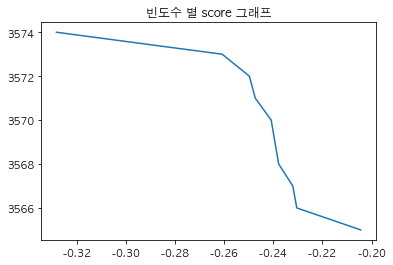

냄새 -0.3283103812527327
허름 -0.2608291698118087
요조 -0.24974551605385387
유흥 -0.24735203974112369
호스텔 -0.2408634849676359
이유 -0.2393547393875934
방음 -0.23781422254863885
내부 -0.23206946609921372
다만 -0.23044230839943136
진짜 -0.2043882922942256


In [38]:
neg_top10_str = [invert_index_vectorizer[coef[1]] for coef in coef_neg_index[:10]]
neg_top10_score = [coef[0] for coef in coef_neg_index[:10]]
text_neg = [int(x) for x in invert_index_vectorizer]

text_neg.sort()
# text_neg.reverse()
text_neg_score_top = text[:10]

plt.bar(neg_top10_str, text_neg_score_top)
plt.plot(neg_top10_score)
plt.title('가장 많이 사용된 부정단어 TOP10')
plt.show()

plt.plot(neg_top10_str,neg_top10_score)
plt.title('단어별 사용 빈도수')
plt.show()

plt.plot(neg_top10_score, text_neg_score_top)
plt.title('빈도수 별 score 그래프')
plt.show()



for coef in coef_neg_index[:10]: # 부정 단어 탑 10 출력
    print(invert_index_vectorizer[coef[1]], coef[0])